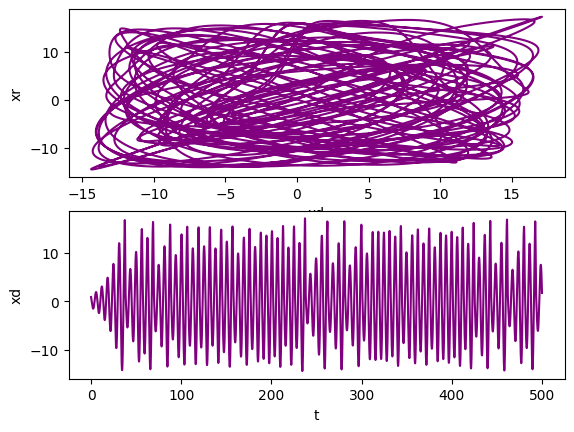

In [2]:
import numpy as np
import scipy.integrate as integrate
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from pandas.plotting import register_matplotlib_converters

a = 0.15;
p = 0.2;
c = 10.0;
w2 = 0.95;
w1 = 0.99;
e = 0.03;

def rossler(H, t=0):
    return np.array([((-w1*H[1])-H[2])+e*(H[3]-H[0]), #xd 0 1
                    (w1*H[0])+(a*H[1]), #yd 1 2
                    p+(H[2]*(H[0]-c)), #zd 2  3
                    ((-w2*H[4])-H[5])+e*(H[0]-H[3]), #xr 3 4
                    (w2*H[3])+(a*H[4]), #yr 4  5
                    p+(H[5]*(H[3]-c))]) #zr 5 6
                    
                    

T = 1000000; T0 = 400000;
t = np.linspace(0, 500, T)
#t = np.linspace(0, T/2, T)
#t = np.arange(0.1, 10000, 0.01)
#T0 = 920000


#H0 = [0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.1, 0.1, 0.1]
#H0 = [0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 1.05, 1.05, 1.05 ]
H0 = [0.9, 0.9, 0.9, 0.9, 0.9, 0.9 ]
#H0 = [0.001, 0.001, 0.001, 0.001, 0.001, 0.001,]
H, infodict = integrate.odeint(rossler, H0, t, full_output=True)

fig, axs = plt.subplots(2)
axs[0].plot(H[T0:,0],H[T0:,3],c='purple') #xd xr
#axs[1].plot(H[T0:,3],H[T0:,6],c='purple') #xr,xa
axs[1].plot(t,H[:,0],c='purple')

#plt.plot(H[:,3],H[:,6],c='purple') #xr,xa
#plt.plot(H[1000:,0],H[1000:,3],c='purple')
plt.setp(axs[0], xlabel='xd')
plt.setp(axs[0], ylabel='xr')
plt.setp(axs[1], xlabel='t')
plt.setp(axs[1], ylabel='xd')

plt.show()
#v = np.array(np.meshgrid(H[T0:,0], H[T0:,3])).T.reshape(-1, 2)
#v = np.array(np.meshgrid(H[T0:,3], t[T0:])).T.reshape(-1, 2)
#print(t[T0:])
#np.savetxt('xt.csv', v, delimiter=",")

#print(len(H[T0:,0]))







In [3]:
q = np.vstack((H[T0:,0],t[T0:])).T
df = pd.DataFrame(q, columns = ['x','t'])

df1 = pd.DataFrame(H[T0:,0])
print(df)
print(df1)

                x         t
0       11.516342  200.0002
1       11.520801  200.0007
2       11.525257  200.0012
3       11.529711  200.0017
4       11.534162  200.0022
...           ...       ...
599995   1.747423  499.9980
599996   1.743580  499.9985
599997   1.739737  499.9990
599998   1.735893  499.9995
599999   1.732049  500.0000

[600000 rows x 2 columns]
                0
0       11.516342
1       11.520801
2       11.525257
3       11.529711
4       11.534162
...           ...
599995   1.747423
599996   1.743580
599997   1.739737
599998   1.735893
599999   1.732049

[600000 rows x 1 columns]


<Axes: xlabel='t', ylabel='x'>

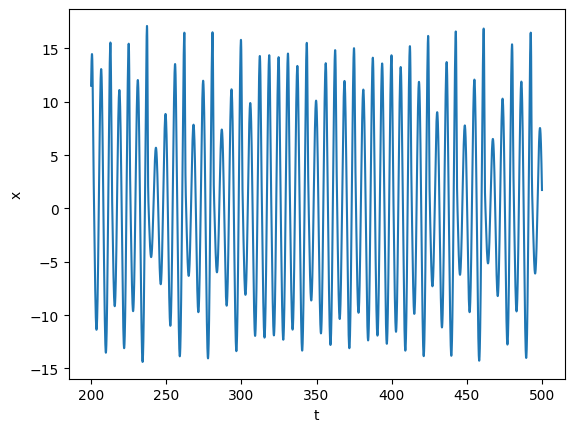

In [4]:
sns.lineplot(x='t', y='x', data=df)

<Axes: >

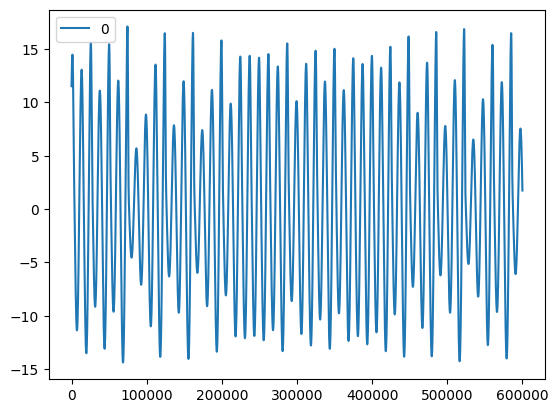

In [5]:
df1.plot()

In [6]:
t1 = t[T0:]
print(t1)

[200.0002 200.0007 200.0012 ... 499.999  499.9995 500.    ]


In [7]:
def df_to_X_y(df,t, window_size=5):
  df_as_np = df.to_numpy()
  X = []
  y = []
  for i in range(len(df_as_np)-window_size):
    row=[a for a in df_as_np[i:i+5]]
    X.append(row)
    label=df_as_np[i+5]
    y.append(label)
  return np.array(X),np.array(y)

In [8]:
WINDOW_SIZE = 5
X,y = df_to_X_y(df1,t1,WINDOW_SIZE)
X.shape, y.shape

((599995, 5, 1), (599995, 1))

In [9]:
y=y.flatten()

In [10]:
X_train, y_train = X[:500000], y[:500000]
X_val, y_val = X[500000:550000], y[500000:550000]
X_test, y_test = X[550000:], y[550000:]
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((500000, 5, 1), (500000,), (50000, 5, 1), (50000,), (49995, 5, 1), (49995,))

In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

model1 = Sequential()
model1.add(InputLayer((5, 1)))
model1.add(LSTM(64))
model1.add(Dense(8, 'relu'))
model1.add(Dense(1, 'linear'))

model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                16896     
                                                                 
 dense (Dense)               (None, 8)                 520       
                                                                 
 dense_1 (Dense)             (None, 1)                 9         
                                                                 
Total params: 17,425
Trainable params: 17,425
Non-trainable params: 0
_________________________________________________________________


In [12]:
cp1 = ModelCheckpoint('model1/', save_best_only=True)
model1.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])

In [13]:
model1.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, callbacks=[cp1])

Epoch 1/10
15624/15625 [============================>.] - ETA: 0s - loss: 2.2798 - root_mean_squared_error: 1.5099

15625/15625 [==============================] - 88s 5ms/step - loss: 2.2796 - root_mean_squared_error: 1.5098 - val_loss: 1.7556e-04 - val_root_mean_squared_error: 0.0132
Epoch 2/10
15620/15625 [============================>.] - ETA: 0s - loss: 1.6136e-04 - root_mean_squared_error: 0.0127

15625/15625 [==============================] - 90s 6ms/step - loss: 1.6135e-04 - root_mean_squared_error: 0.0127 - val_loss: 1.0206e-04 - val_root_mean_squared_error: 0.0101
Epoch 3/10
15625/15625 [==============================] - 84s 5ms/step - loss: 1.3181e-04 - root_mean_squared_error: 0.0115 - val_loss: 1.1593e-04 - val_root_mean_squared_error: 0.0108
Epoch 4/10
15625/15625 [==============================] - 84s 5ms/step - loss: 1.0962e-04 - root_mean_squared_error: 0.0105 - val_loss: 1.2622e-04 - val_root_mean_squared_error: 0.0112
Epoch 5/10
15616/15625 [============================>.] - ETA: 0s - loss: 9.1915e-05 - root_mean_squared_error: 0.0096

15625/15625 [==============================] - 96s 6ms/step - loss: 9.1917e-05 - root_mean_squared_error: 0.0096 - val_loss: 5.7465e-05 - val_root_mean_squared_error: 0.0076
Epoch 6/10
15625/15625 [==============================] - 93s 6ms/step - loss: 7.4627e-05 - root_mean_squared_error: 0.0086 - val_loss: 9.1446e-05 - val_root_mean_squared_error: 0.0096
Epoch 7/10
15624/15625 [============================>.] - ETA: 0s - loss: 6.3760e-05 - root_mean_squared_error: 0.0080

15625/15625 [==============================] - 87s 6ms/step - loss: 6.3758e-05 - root_mean_squared_error: 0.0080 - val_loss: 3.5408e-05 - val_root_mean_squared_error: 0.0060
Epoch 8/10
15625/15625 [==============================] - 85s 5ms/step - loss: 5.2923e-05 - root_mean_squared_error: 0.0073 - val_loss: 4.5605e-05 - val_root_mean_squared_error: 0.0068
Epoch 9/10
15619/15625 [============================>.] - ETA: 0s - loss: 4.5290e-05 - root_mean_squared_error: 0.0067

15625/15625 [==============================] - 92s 6ms/step - loss: 4.5284e-05 - root_mean_squared_error: 0.0067 - val_loss: 2.5253e-05 - val_root_mean_squared_error: 0.0050
Epoch 10/10
15625/15625 [==============================] - 89s 6ms/step - loss: 3.9679e-05 - root_mean_squared_error: 0.0063 - val_loss: 3.3639e-05 - val_root_mean_squared_error: 0.0058


In [14]:
from tensorflow.keras.models import load_model
model1 = load_model('model1/')

In [15]:
train_predictions = model1.predict(X_train).flatten()
train_results = pd.DataFrame(data={'Train Predictions':train_predictions, 'Actuals':y_train})
train_results

15625/15625 [==============================] - 41s 3ms/step


,Train Predictions,Actuals
0,11.537662,11.538611
1,11.542111,11.543056
2,11.546559,11.547499
3,11.551003,11.551939
4,11.555447,11.556377
...,...,...
499995,1.441056,1.439248
499996,1.436967,1.435157
499997,1.432877,1.431066
499998,1.428786,1.426974


In [ ]:
plt.plot(train_results['Train Predictions'],'.')
plt.plot(train_results['Actuals'],c='black')

In [ ]:
val_predictions = model1.predict(X_val).flatten()
val_results = pd.DataFrame(data={'Val Predictions':val_predictions, 'Actuals':y_val})
val_results

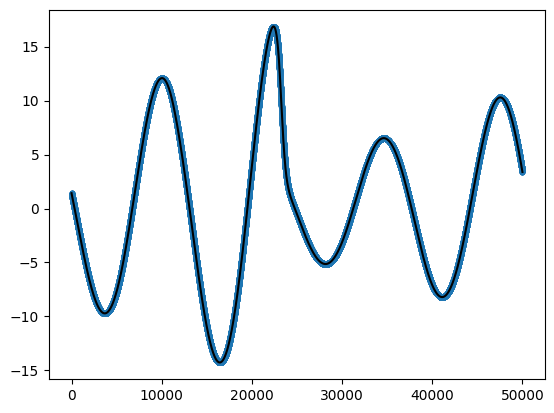

In [18]:
plt.plot(val_results['Val Predictions'],'.')
plt.plot(val_results['Actuals'],c='black')

In [ ]:
test_predictions = model1.predict(X_test).flatten()
test_results = pd.DataFrame(data={'test Predictions':test_predictions, 'Actuals':y_test})
test_results


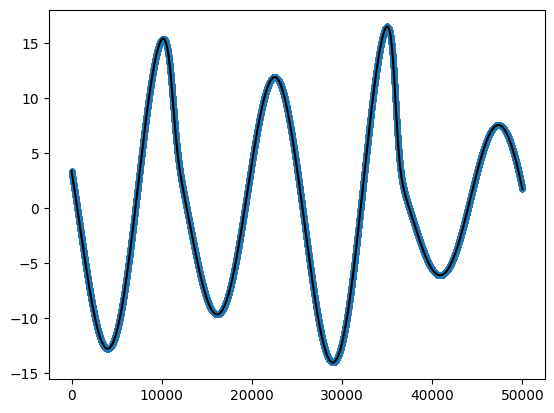

In [20]:
plt.plot(test_results['test Predictions'],'.')
plt.plot(test_results['Actuals'],c='black')

In [ ]:
from sklearn.metrics import mean_squared_error as mse

def plot_predictions1(model, X, y):
  predictions = model.predict(X).flatten()
  df = pd.DataFrame(data={'Predictions':predictions, 'Actuals':y})
  plt.plot(df['Predictions'])
  plt.plot(df['Actuals'])
  return df, mse(y, predictions)

1563/1563 [==============================] - 4s 3ms/step


(       Predictions   Actuals
 0         3.381076  3.379206
 1         3.376049  3.374185
 2         3.371020  3.369163
 3         3.365991  3.364140
 4         3.360959  3.359115
 ...            ...       ...
 49990     1.748819  1.747423
 49991     1.744982  1.743580
 49992     1.741145  1.739737
 49993     1.737306  1.735893
 49994     1.733467  1.732049
 
 [49995 rows x 2 columns],
 2.984622638032608e-05)

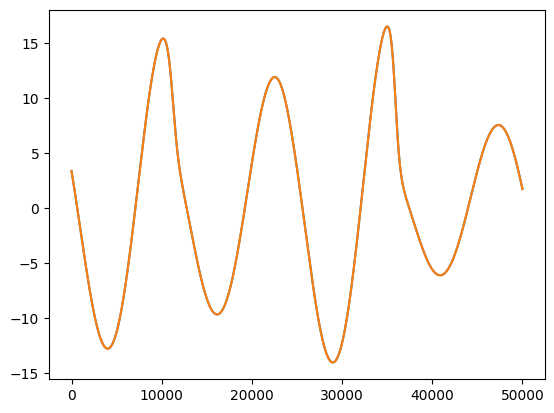

In [22]:
plot_predictions1(model1, X_test, y_test)

In [ ]:
pred = model1.predict(X_test)
pred = pd.DataFrame(pred)

In [24]:
pred1 = model1.predict(X_train)
pred1 = pd.DataFrame(pred1)
pred1.to_csv(f"xd_003.csv",index=False,header=None)

15625/15625 [==============================] - 43s 3ms/step


In [ ]:
!pip install tensorflow_addons

In [26]:
import tensorflow_addons as tfa
metric = tfa.metrics.r_square.RSquare()
metric.update_state(y_train, train_predictions)
result = metric.result()
result.numpy()

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


0.9999996